In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Code 12.1

In [2]:
d = pd.read_csv('Data/reedfrogs.csv', sep=",")
print(d.shape)
d.head(8)

(48, 5)


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9
5,10,no,small,9,0.9
6,10,no,small,10,1.0
7,10,no,small,9,0.9


#### Code 12.2

In [3]:
# make the tank cluster variable
tank = np.arange(d.shape[0])
# fit
with pm.Model() as m_12_1:
    a_tank = pm.Normal('a_tank', 0, 5, shape=d.shape[0])
    p = pm.math.invlogit(a_tank[tank])
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    trace_12_1 = pm.sample(2000, tune=2000, njobs=4)
# pm.summary(trace_12_1, alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_tank]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:08<00:00, 1894.89draws/s]


#### Code 12.3

In [5]:
with pm.Model() as m_12_2:
    a = pm.Normal('a', 0., 1.)
    sigma = pm.HalfCauchy('sigma', 1.)
    a_tank = pm.Normal('a_tank', a, sigma, shape=d.shape[0])
    p = pm.math.invlogit(a_tank[tank])
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    trace_12_2 = pm.sample(2000, tune=2000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:05<00:00, 3104.86draws/s]


#### Code 12.4

In [7]:
comp_df = pm.compare({m_12_1 : trace_12_1,
                      m_12_2 : trace_12_2},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m12.1', 'm12.2'])
comp_df = comp_df.set_index('model')
comp_df

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m12.2,200.51,21.12,0,0.56,7.18,0,1
m12.1,201.02,22.44,0.52,0.44,9.17,4.44,1


#### Code 12.5

In [8]:
# extract PyMC3 samples
post = pm.trace_to_dataframe(trace_12_2, varnames=['a_tank'])

# compute median intercept for each tank
# also transform to probability with logistic
d.loc[:, 'propsurv_est'] = pd.Series(logistic(post.median(axis=0).values), index=d.index)

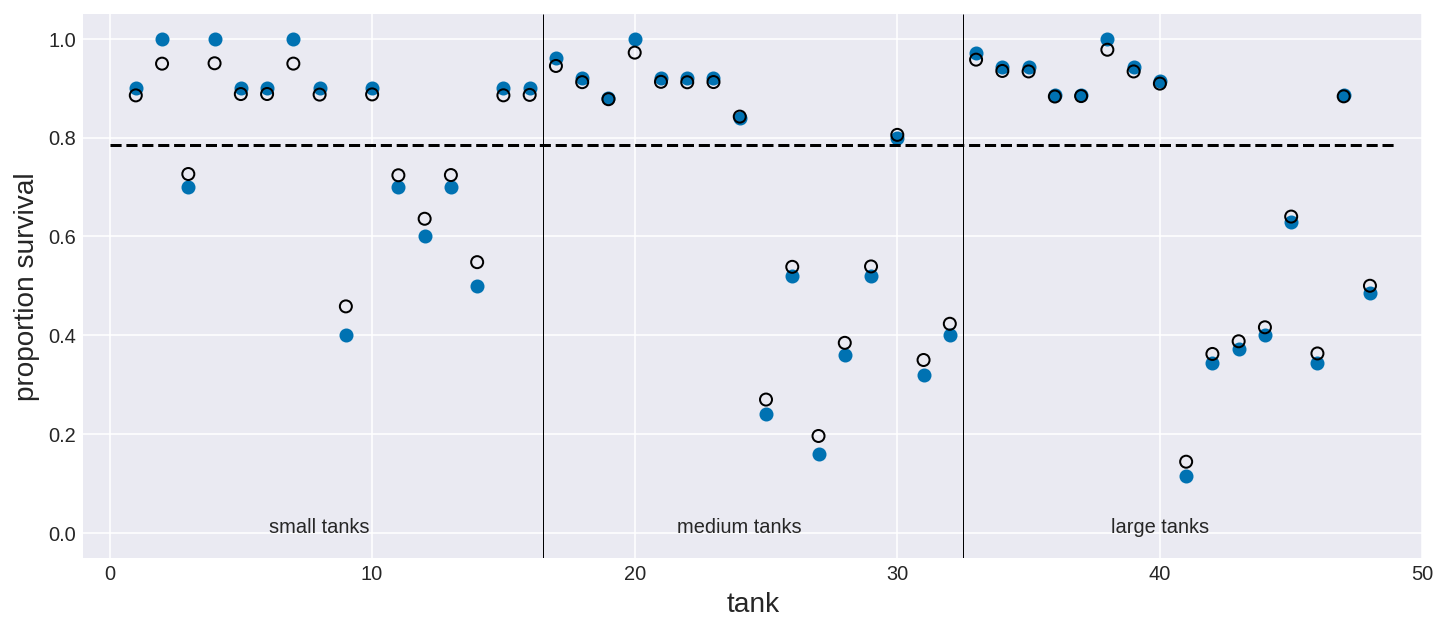

In [9]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
# display raw proportions surviving in each tank
ax.scatter(np.arange(1, 49), d.propsurv)
ax.scatter(np.arange(1, 49), d.propsurv_est,
             facecolors='none', edgecolors='k', lw=1)
ax.hlines(logistic(np.median(trace_12_2['a'], axis=0)), 0, 49, linestyles='--')
ax.vlines([16.5, 32.5], -.05, 1.05, lw=.5)
ax.text(8, 0, "small tanks", horizontalalignment='center')
ax.text(16+8, 0, "medium tanks", horizontalalignment='center')
ax.text(32+8, 0, "large tanks", horizontalalignment='center')
ax.set_xlabel('tank', fontsize=14)
ax.set_ylabel('proportion survival', fontsize=14)
ax.set_xlim(-1, 50)
ax.set_ylim(-.05, 1.05);

#### Code 12.6

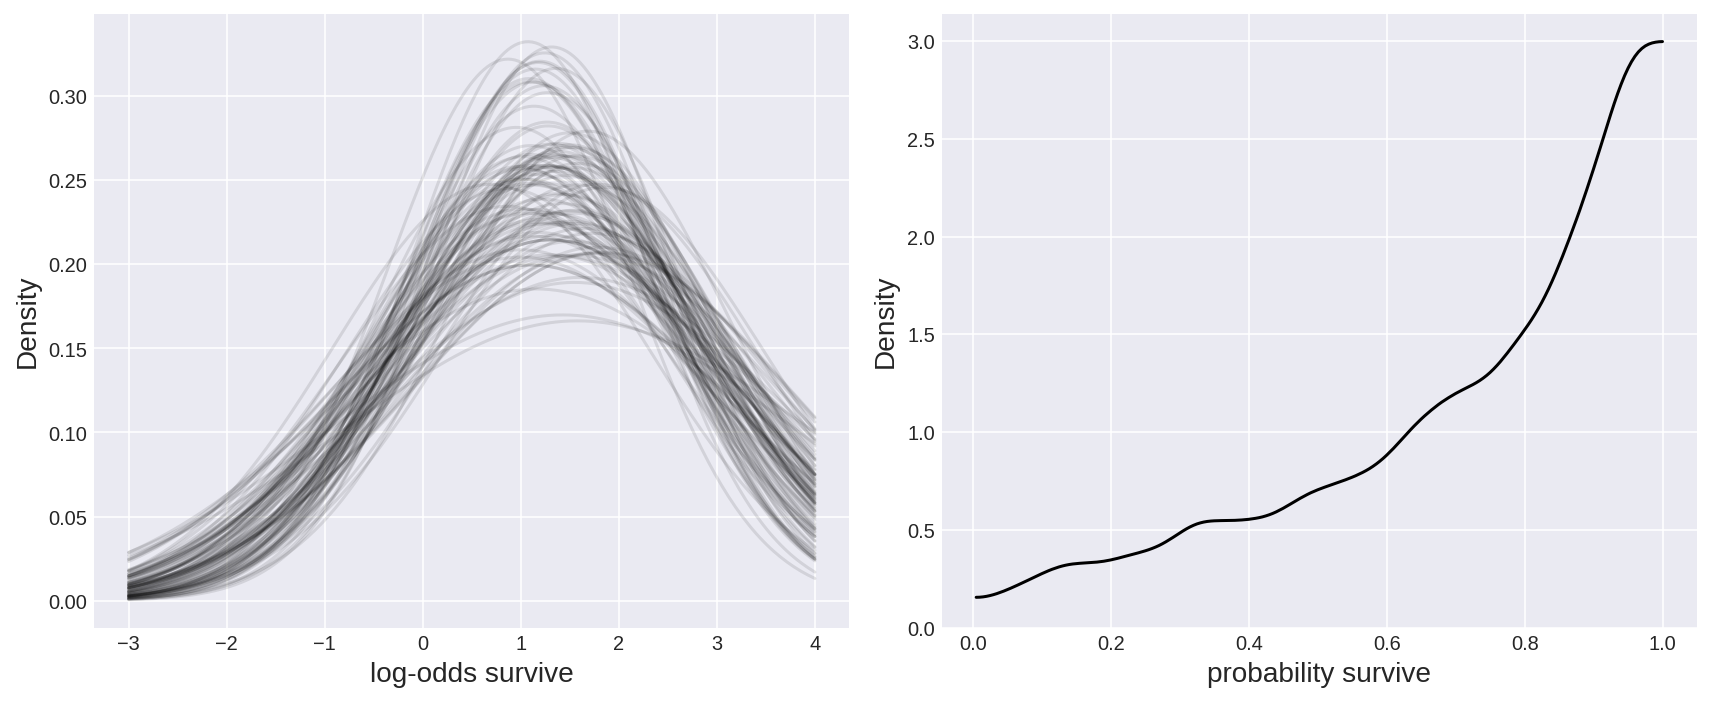

In [10]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
# show first 100 populations in the posterior
xrange = np.linspace(-3, 4, 200)
postcurve = [stats.norm.pdf(xrange, loc=trace_12_2['a'][i], scale=trace_12_2['sigma'][i]) for i in range(100)]
ax[0].plot(xrange, np.asarray(postcurve).T,
           alpha=.1, color='k')
ax[0].set_xlabel('log-odds survive', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14);
# sample 8000 imaginary tanks from the posterior distribution
sim_tanks = np.random.normal(loc=trace_12_2['a'], scale=trace_12_2['sigma'])
# transform to probability and visualize
pm.kdeplot(logistic(sim_tanks), ax=ax[1], color='k')
ax[1].set_xlabel('probability survive', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
plt.tight_layout();
# dens( logistic(sim_tanks) , xlab="probability survive" )

#### Code 12.7

In [11]:
a, sigma, nponds = 1.4, 1.5, 60
ni = np.repeat([5, 10, 25, 35], 15)

#### Code 12.8

In [12]:
a_pond = np.random.normal(loc=a, scale=sigma, size=nponds)

#### Code 12.9

In [13]:
dsim = pd.DataFrame(dict(pond=np.arange(nponds), ni=ni, true_a=a_pond))

#### Code 12.10
Data types related. Python is dynamically-typed.

#### Code 12.11

In [14]:
dsim.loc[:, 'si'] = np.random.binomial(dsim['ni'], logistic(dsim['true_a']))

#### Code 12.12

In [15]:
dsim.loc[:, 'p_nopool'] = dsim.si / dsim.ni

#### Code 12.13

In [16]:
with pm.Model() as m_12_3:
    a = pm.Normal('a', 0., 1.)
    sigma = pm.HalfCauchy('sigma', 1.)
    a_pond = pm.Normal('a_pond', a, sigma, shape=nponds)
    p = pm.math.invlogit(a_pond[dsim.pond.values])
    si = pm.Binomial('si', n=dsim.ni.values, p=p, observed=dsim.si)
    trace_12_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_pond, sigma_log__, a]
100%|██████████| 2000/2000 [00:03<00:00, 590.92it/s]


#### Code 12.14

In [17]:
summary_12_3 = pm.summary(trace_12_3, alpha=.11)
summary_12_3.iloc[[0, 1, 2, -3, -2, -1],:].round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.27,0.26,0.01,0.87,1.73,1924.97,1.0
a_pond__0,2.84,1.32,0.03,0.83,4.78,2017.67,1.0
a_pond__1,2.82,1.32,0.03,0.66,4.78,2047.12,1.0
a_pond__58,2.76,0.66,0.02,1.76,3.83,1810.37,1.0
a_pond__59,0.57,0.38,0.01,-0.03,1.15,4466.13,1.0
sigma,1.82,0.25,0.01,1.43,2.19,988.58,1.0


#### Code 12.15

In [18]:
estimated_a_pond = pm.summary(trace_12_3, alpha=.11, varnames=['a_pond'])
dsim.loc[:, 'p_partpool'] = logistic(estimated_a_pond['mean'].values)

#### Code 12.16

In [19]:
dsim.loc[:, 'p_true'] = logistic(dsim['true_a'].values)

#### Code 12.17

In [20]:
nopool_error = np.abs(dsim.p_nopool - dsim.p_true)
partpool_error = np.abs(dsim.p_partpool - dsim.p_true)

#### Code 12.18

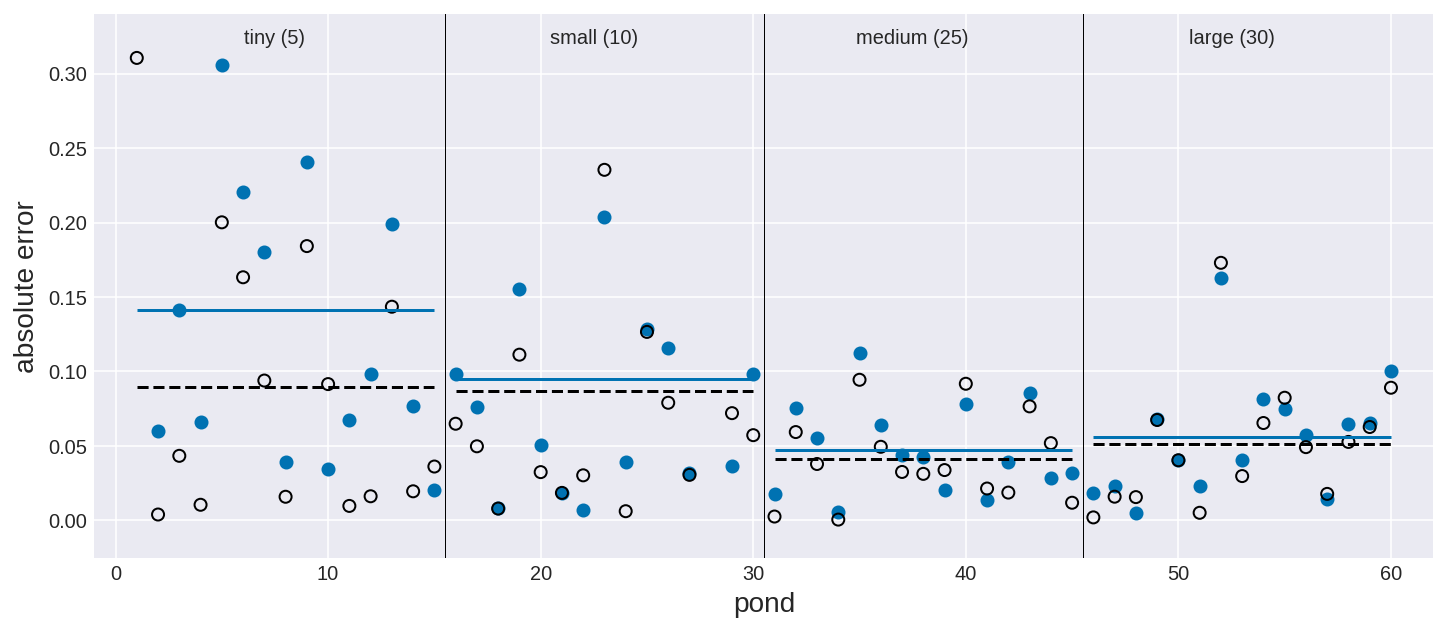

In [21]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
xrange = np.arange(60)
xrange_ = xrange.reshape((4, 15))
# display raw proportions surviving in each tank
ax.scatter(xrange+1, nopool_error)
ax.scatter(xrange+1, partpool_error,
             facecolors='none', edgecolors='k', lw=1)
ax.vlines(xrange_[1:,0]+.5, -.025, 0.35, lw=.5)

textall = ["tiny (5)", "small (10)", "medium (25)", "large (30)"]
for isem in range(4):
    ax.hlines(nopool_error[xrange_[isem, :]].mean(), 
              xrange_[isem, 0]+1, xrange_[isem, -1]+1, color='C0')
    ax.hlines(partpool_error[xrange_[isem, :]].mean(), 
              xrange_[isem, 0]+1, xrange_[isem, -1]+1, color='k', linestyles='--')
    ax.text(xrange_[isem, 7]+.5, 0.32, textall[isem], horizontalalignment='center')
ax.set_xlabel('pond', fontsize=14)
ax.set_ylabel('absolute error', fontsize=14)
ax.set_xlim(-1, 62)
ax.set_ylim(-.025, 0.34);

#### Code 12.19

This part is more Stan and rethinking related. To do the same in PyMC3 (i.e., avoide compiling the same model twice), you need to set up the input data with `theano.shared` or use [sampled](https://github.com/ColCarroll/sampled), a functional decorator for PyMC3.

#### Code 12.20

In [22]:
y1 = np.random.normal(10., 1., 10000)
y2 = 10. + np.random.normal(0., 1., 10000)

#### Code 12.21

In [18]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = (d.actor - 1).astype(int)
Nactor = len(d.actor.unique())

print (d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 8 columns):
actor           504 non-null int64
recipient       252 non-null float64
condition       504 non-null int64
block           504 non-null int64
trial           504 non-null int64
prosoc_left     504 non-null int64
chose_prosoc    504 non-null int64
pulled_left     504 non-null int64
dtypes: float64(1), int64(7)
memory usage: 31.6 KB
None


In [14]:


with pm.Model() as m_12_4:
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    
    a = pm.Normal('a', 0, 10)
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    a_actor = pm.Normal('a_actor', 0., sigma_actor, shape=Nactor)

    p = pm.math.invlogit(a + a_actor[d.actor.values] + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_12_4 = pm.sample(5000, tune=1000, njobs=4)
# pm.traceplot(trace_12_4)
# pm.summary(trace_12_4, alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_actor, sigma_actor, a, bpC, bp]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:43<00:00, 551.11draws/s]
The number of effective samples is smaller than 25% for some parameters.


#### Code 12.22

In [24]:
total_a_actor = np.asarray([trace_12_4['a'] + trace_12_4['a_actor'][:, i] for i in range(Nactor)])
total_a_actor.mean(axis=1).round(2)

array([-0.71,  4.62, -1.02, -1.02, -0.72,  0.23,  1.77])

#### Code 12.23

In [25]:
d.block = (d.block - 1).astype(int)
Nblock = len(d.block.unique())

with pm.Model() as m_12_5:
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    
    a = pm.Normal('a', 0, 10)
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    a_actor = pm.Normal('a_actor', 0., sigma_actor, shape=Nactor)

    sigma_block = pm.HalfCauchy('sigma_block', 1.)
    a_block = pm.Normal('a_block', 0., sigma_block, shape=Nblock)
    
    p = pm.math.invlogit(a + a_actor[d.actor.values] + a_block[d.block.values]
                         + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_12_5 = pm.sample(6000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_block, sigma_block_log__, a_actor, sigma_actor_log__, a, bpC, bp]
100%|██████████| 7000/7000 [01:16<00:00, 91.30it/s]
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6553345934744974, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6939036923972168, but should be close to 0.8. Try to increase the number of tuning steps.
There were 359 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5625776701282227, but should be close to 0.8. Try to increase the number of tuning steps.
There were 101 divergences after tuning. Incr

#### Code 12.24

In [26]:
pm.summary(trace_12_5, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
bp,0.82,0.25,0.00,0.41,1.21,8887.85,1.00
bpC,-0.10,0.31,0.01,-0.55,0.40,89.61,1.02
a,0.42,0.92,0.01,-1.07,1.74,4304.73,1.00
a_actor__0,-1.14,0.93,0.02,-2.56,0.29,4376.34,1.00
a_actor__1,4.18,1.57,0.04,1.92,6.56,995.85,1.00
a_actor__2,-1.47,0.93,0.01,-2.88,-0.05,4524.65,1.00
a_actor__3,-1.45,0.93,0.01,-2.80,0.04,4622.25,1.00
a_actor__4,-1.14,0.93,0.01,-2.65,0.20,4411.26,1.00
a_actor__5,-0.21,0.93,0.01,-1.57,1.26,4767.02,1.00
a_actor__6,1.32,0.95,0.01,-0.07,2.82,4663.12,1.00


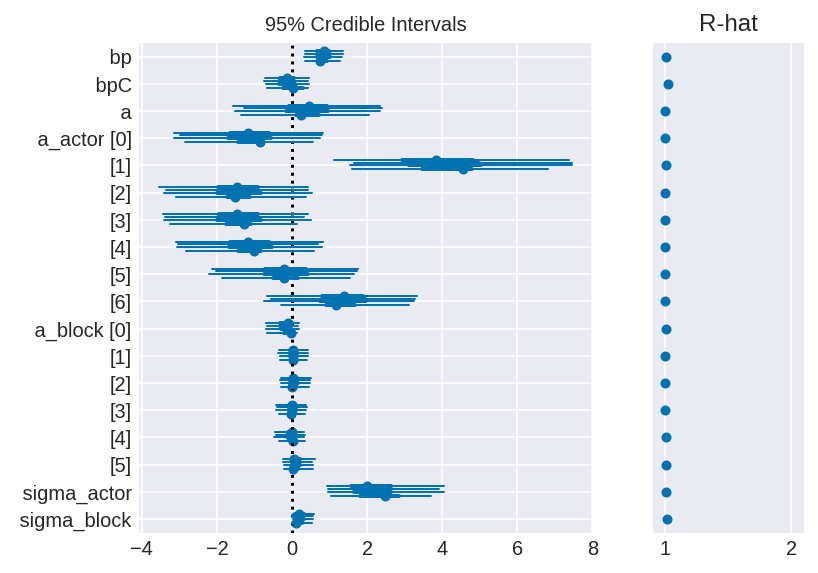

In [27]:
pm.forestplot(trace_12_5);

#### Code 12.25

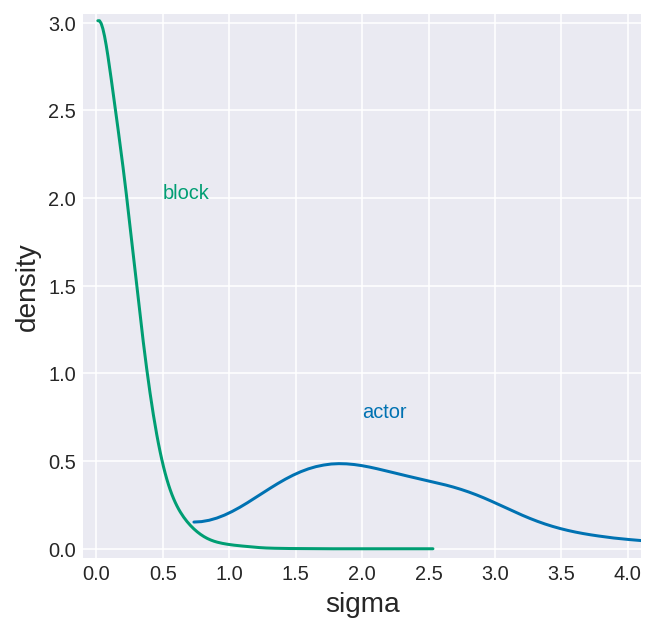

In [28]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
pm.kdeplot(trace_12_5['sigma_actor'], ax=ax)
pm.kdeplot(trace_12_5['sigma_block'], ax=ax)
ax.text(2, 0.75, "actor", color='C0')
ax.text(0.5, 2, "block", color='C1')
ax.set_xlabel('sigma', fontsize=14)
ax.set_ylabel('density', fontsize=14)
ax.set_xlim(-0.1, 4.1)
ax.set_ylim(-0.05, 3.05);

#### Code 12.26

In [29]:
comp_df = pm.compare({m_12_4 : trace_12_4, 
                      m_12_5 : trace_12_5},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m12.4', 'm12.5'])
comp_df = comp_df.set_index('model')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m12.4,531.54,8.2,0,0.6,19.49,0,0
m12.5,532.32,10.08,0.78,0.4,19.59,1.69,0


#### Code 12.27

In [30]:
chimp = 2 - 1
sel_actor = np.where((d.actor == (chimp)).values)[0]
_, uni_cond = np.unique(d.loc[sel_actor, ['condition', 'prosoc_left']], 
                        axis=0, return_index=True, )
d.loc[sel_actor[uni_cond], :].head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
73,1,NaN,0,0,3,0,0,1
72,1,NaN,0,0,1,1,1,1
108,1,7.0,1,0,2,0,0,1
116,1,5.0,1,1,16,1,1,1


In [31]:
ppc = pm.sample_ppc(trace=trace_12_4, samples=1000, model=m_12_4)

100%|██████████| 1000/1000 [00:01<00:00, 787.83it/s]


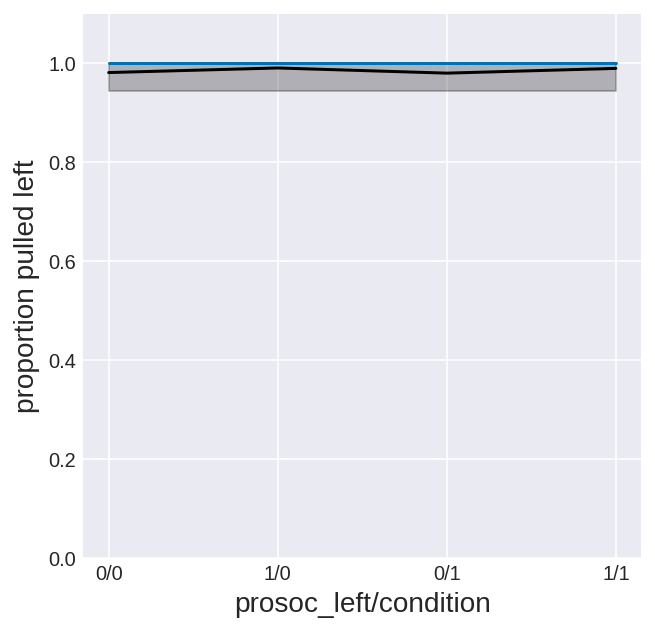

In [32]:
rt = ppc['pulled_left'][:, sel_actor]

pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left[sel_actor].values==pl) &
                                     (d.condition[sel_actor].values==cp)]))
    pred_mean[i] = tmp
    
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean, alpha=.11)

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.fill_between(range(4), hpd[:,1], hpd[:,0], alpha=0.25, color='k')
ax.plot(mp, color='k')
chimps = d.groupby(['actor', 'prosoc_left', 'condition']).agg('mean')['pulled_left'].values.reshape(7, -1)
ax.plot(chimps[chimp], 'C0')

ax.set_ylim(0, 1.1)
ax.set_xlabel("prosoc_left/condition", fontsize=14)
ax.set_ylabel("proportion pulled left", fontsize=14)
plt.xticks(range(4), ("0/0","1/0","0/1","1/1"));

#### Code 12.28

In [33]:
post = pm.trace_to_dataframe(trace_12_4)
post.head()

,bp,bpC,a,a_actor__0,a_actor__1,a_actor__2,a_actor__3,a_actor__4,a_actor__5,a_actor__6,sigma_actor
0,0.780470,-0.314568,0.769134,-1.684101,4.827312,-1.370782,-2.114065,-1.578276,-0.086279,0.837004,2.410176
1,0.718914,-0.049423,0.402270,-1.037082,3.711503,-1.595109,-1.243566,-1.178228,-0.255821,1.527920,2.311447
2,0.799273,0.005496,0.433965,-1.242879,3.261599,-1.259011,-1.609766,-1.019749,-0.178504,1.158526,1.201502
3,0.752321,-0.071563,0.475441,-0.913435,2.358281,-1.387385,-1.217349,-1.053174,-0.205176,1.221189,1.350571
4,0.557527,0.112460,0.673565,-1.340724,3.045535,-1.349606,-1.599339,-0.811255,-0.428232,1.205874,1.546388


#### Code 12.29

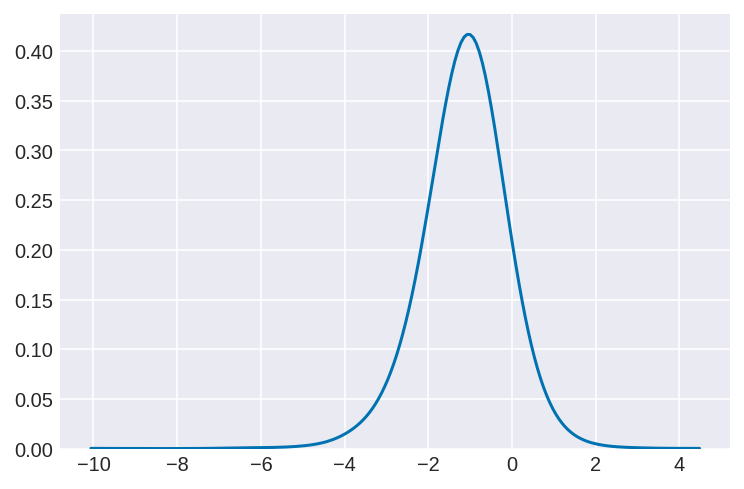

In [34]:
pm.kdeplot(trace_12_4['a_actor'][:, 5-1]);

#### Code 12.30

In [35]:
def p_link(prosoc_left, condition, actor, trace):
    logodds = trace['a'] + \
                trace['a_actor'][:, actor] + \
                (trace['bp'] + trace['bpC'] * condition) * prosoc_left
    return logistic(logodds)

#### Code 12.31

In [36]:
prosoc_left = [0,1,0,1]
condition = [0,0,1,1]

pred_raw = np.asarray([p_link(p_l, c_d, 2-1, trace_12_4) 
                       for p_l, c_d in zip(prosoc_left, condition)]).T
pred_p = pred_raw.mean(axis=0)
pred_p_PI = pm.hpd(pred_raw, alpha=.11)

#### Code 12.32

In [37]:
d_pred = pd.DataFrame(dict(prosoc_left=[0, 1, 0, 1],
                           condition=[0, 0, 1, 1], 
                           actor = np.repeat(2-1,4)))

#### Code 12.33

In [38]:
# replace varying intercept samples with zeros
# 1000 samples by 7 actors
a_actor_zeros = np.zeros((1000,7))

#### Code 12.34

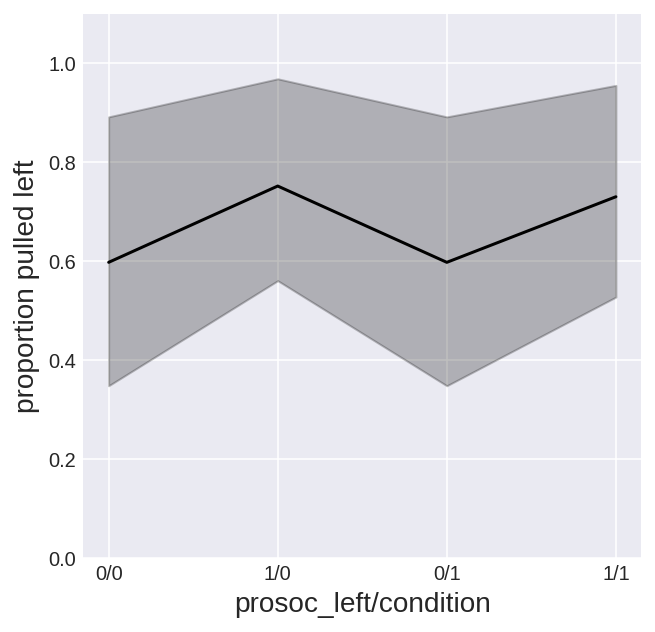

In [39]:
def p_link(prosoc_left, condition, actor_sim, trace):
    Nsim = actor_sim.shape[0]//trace.nchains
    trace = trace[:Nsim]
    logodds = trace['a'] + \
                np.mean(trace['a_actor']*actor_sim, axis=1) + \
                (trace['bp'] + trace['bpC'] * condition) * prosoc_left
    return logistic(logodds)

pred_raw = np.asarray([p_link(p_l, c_d, a_actor_zeros, trace_12_4) 
                       for p_l, c_d in zip(prosoc_left, condition)]).T
pred_p = pred_raw.mean(axis=0)
pred_p_PI = pm.hpd(pred_raw, alpha=.11)

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.fill_between(range(4), pred_p_PI[:,1], pred_p_PI[:,0], alpha=0.25, color='k')
ax.plot(pred_p, color='k')

ax.set_ylim(0, 1.1)
ax.set_xlabel("prosoc_left/condition", fontsize=14)
ax.set_ylabel("proportion pulled left", fontsize=14)
plt.xticks(range(4), ("0/0","1/0","0/1","1/1"));

#### Code 12.35

In [40]:
# replace varying intercept samples with simulations
sigma_actor = trace_12_4.get_values('sigma_actor')
a_actor_sims = np.random.normal(loc=0, 
                                scale=np.reshape(sigma_actor[:7000], (1000, 7)))

#### Code 12.36

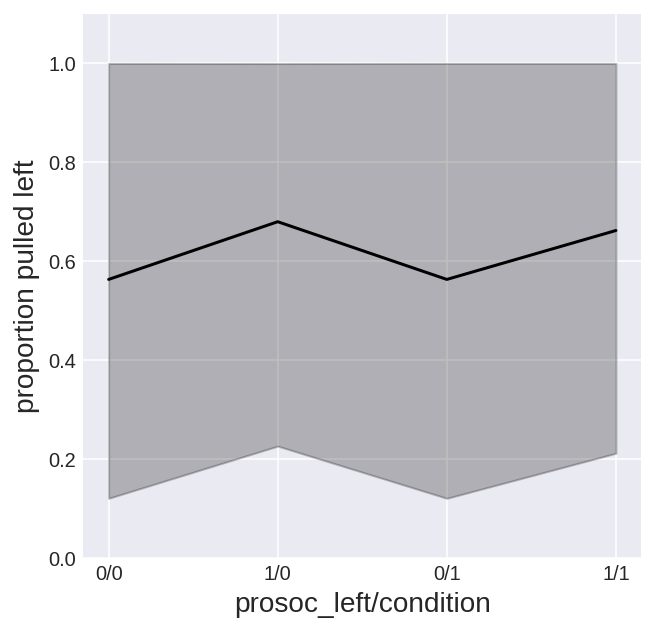

In [41]:
pred_raw = np.asarray([p_link(p_l, c_d, a_actor_sims, trace_12_4) 
                       for p_l, c_d in zip(prosoc_left, condition)]).T
pred_p = pred_raw.mean(axis=0)
pred_p_PI = pm.hpd(pred_raw, alpha=.11)

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.fill_between(range(4), pred_p_PI[:,1], pred_p_PI[:,0], alpha=0.25, color='k')
ax.plot(pred_p, color='k')

ax.set_ylim(0, 1.1)
ax.set_xlabel("prosoc_left/condition", fontsize=14)
ax.set_ylabel("proportion pulled left", fontsize=14)
plt.xticks(range(4), ("0/0","1/0","0/1","1/1"));

#### Code 12.37

In [42]:
def sim_actor(tr, i):
    sim_a_actor = np.random.randn()*tr['sigma_actor'][i]
    P = np.array([0, 1, 0, 1])
    C = np.array([0, 1, 0, 1])
    p = logistic(tr['a'][i] + sim_a_actor + (tr['bp'][i] + tr['bpC'][i]*C)*P)
    return p

# sim_actor(trace_12_4, 0)

#### Code 12.38

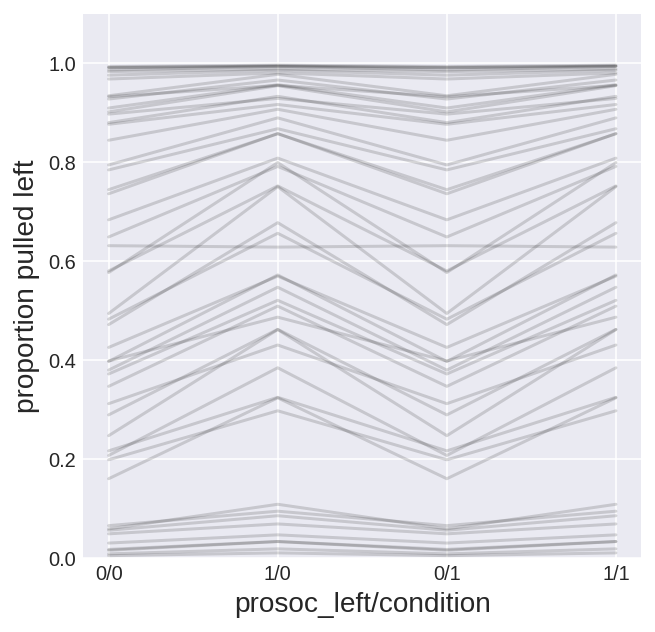

In [43]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(50):
    ax.plot(sim_actor(trace_12_4, i), color='k', alpha=.15)

ax.set_ylim(0, 1.1)
ax.set_xticks(range(4), ("0/0","1/0","0/1","1/1"))
ax.set_xlabel("prosoc_left/condition", fontsize=14)
ax.set_ylabel("proportion pulled left", fontsize=14)
plt.xticks(range(4), ("0/0","1/0","0/1","1/1"));

#### Code 12.39

In [44]:
dk = pd.read_csv('Data/Kline', sep=";")
dk.loc[:, 'log_pop'] = np.log(dk.population)
Nsociety = dk.shape[0]
dk.loc[:, 'society'] = np.arange(Nsociety)

with pm.Model() as m_12_6:
    sigma_society = pm.HalfCauchy('sigma_society', 1)
    a_society = pm.Normal('a_society', 0, sigma_society, shape=Nsociety),
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 1)
    lam = pm.math.exp(a + a_society + bp*dk.log_pop)
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_12_6 = pm.sample(5000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bp, a, a_society, sigma_society_log__]
100%|██████████| 6000/6000 [01:08<00:00, 88.13it/s]
The number of effective samples is smaller than 25% for some parameters.


#### Code 12.40

In [45]:
sigma_society = trace_12_6.get_values('sigma_society', combine=True)[:, None]
a_society_sims = np.random.normal(loc=0, scale=sigma_society)
log_pop_seq = np.linspace(6, 14, 30)
a_post = trace_12_6.get_values(varname='a', combine=True)[:, None]
bp_post = trace_12_6.get_values(varname='bp', combine=True)[:, None]
link_m12_6 = np.exp(a_post + a_society_sims + bp_post*log_pop_seq)

#### Code 12.41

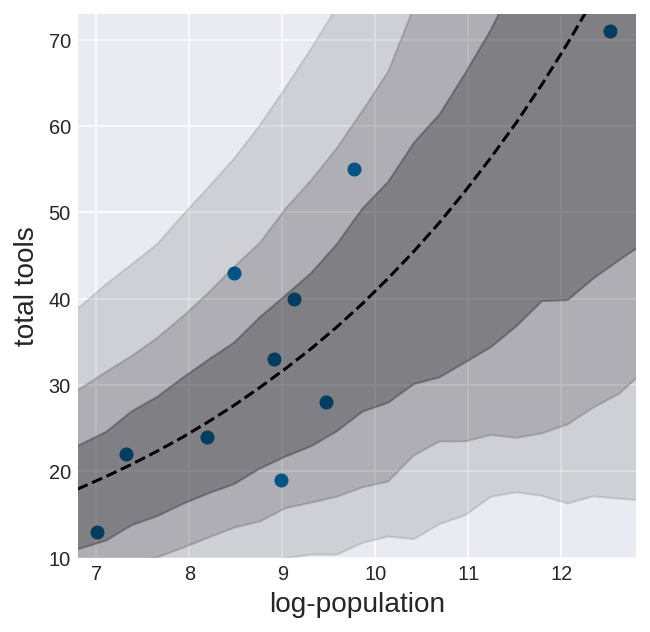

In [46]:
# plot raw data
_, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(dk.log_pop, dk.total_tools)

axes.plot(log_pop_seq, np.median(link_m12_6, axis=0), '--', color='k')

for alpha in [.67, .89, .97]: 
    alpha = 1-alpha
    mu_hpd = pm.hpd(link_m12_6, alpha=alpha)
    axes.fill_between(log_pop_seq,
                      mu_hpd[:,0], mu_hpd[:,1], alpha=alpha*.5+.1, color='k')

axes.set_xlabel('log-population', fontsize=14)
axes.set_ylabel('total tools', fontsize=14)
axes.set_xlim(6.8, 12.8)
axes.set_ylim(10, 73);

In [47]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.3
IPython 6.3.1
PyMC3 3.4.1
NumPy 1.14.2
Pandas 0.22.0
SciPy 1.0.1
Matplotlib 2.2.2

